In [1]:
import resources.Get_Vectorised_Data as Get_Vectorised_Data
from resources.single_data.RF_AR import RF_AR
from resources.vectorised_data.MISO.ARX_repr.RF_ARX import RF_ARX
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import julia
from julia import Pkg
from julia import Main
%load_ext julia.magic

[*********************100%***********************]  2 of 2 completed
make_diff()
                ^GSPC       ^IXIC
Date                             
2021-01-04 -55.420166 -189.830078
2021-01-05  26.210205  120.509766
2021-01-06  21.279785  -78.169922
2021-01-07  55.650146  326.690430
2021-01-08  20.889893  134.500000
...               ...         ...
2022-03-21  -1.939941  -55.379883
2022-03-22  50.429688  270.360352
2022-03-23 -55.369629 -186.220703
2022-03-24  63.919922  269.240234
2022-03-25  22.899902  -22.540039

[310 rows x 2 columns]
Initializing Julia interpreter. This may take some time...


In [2]:
szereg = Get_Vectorised_Data.Get_Vectorised_Data(["CL=F", "^IXIC", "^GSPC", "EURUSD=X", "GC=F"], start="2020-09-20", end='2022-01-20', interval="1d").make_diff()
#szereg = pd.read_csv("sim.csv")['x'][:300]
#getter.analiza_statystyczna_szeregu(szereg_pandas=szereg)
szereg.dropna(how='any', inplace=True)
print(szereg.isna().sum())
szereg

[*********************100%***********************]  5 of 5 completed
make_diff()
CL=F        0
EURUSD=X    0
GC=F        0
^GSPC       0
^IXIC       0
dtype: int64


,CL=F,EURUSD=X,GC=F,^GSPC,^IXIC
Date,,,,,
2020-09-22,0.289997,-0.007753,-2.599976,34.510010,184.839844
2020-09-23,0.330002,-0.005963,-38.699951,-78.650146,-330.649414
2020-09-24,0.380001,-0.004982,8.400024,9.670166,39.279297
2020-09-25,-0.060001,0.001470,-10.600098,51.869873,241.290039
2020-09-28,0.349998,-0.003789,15.100098,53.140137,203.970703
...,...,...,...,...,...
2022-01-11,2.989998,-0.002354,20.199951,42.779785,210.620117
2022-01-12,1.419998,0.003606,8.599976,13.280273,34.939453
2022-01-13,-0.519997,0.007517,-6.000000,-67.320312,-381.580078


In [3]:
Pkg.add("DecisionTree")
Main.using("DecisionTree")

    Updating registry at `C:\Users\micuk\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\micuk\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\micuk\.julia\environments\v1.7\Manifest.toml`


In [4]:
cart_ar = RF_ARX(data=szereg, params={"lags": 1}, test_ratio=0.8, to_predict="^IXIC")
opt = cart_ar.cross_validation_rolling_window_julia(dlugosc_okna=1/2, params = {
    "max_depth": 3,
    "min_samples_split": 3,
    "max_n_estimators": 3,
    "min_samples_leaf": 3
})

#cart_ar.fit(params_fit={"max_depth": opt})

2, 1, 2, 2
2, 1, 2, 3
2, 1, 3, 2
2, 1, 3, 3
2, 2, 2, 2
2, 2, 2, 3
2, 2, 3, 2
2, 2, 3, 3
2, 3, 2, 2
2, 3, 2, 3
2, 3, 3, 2
2, 3, 3, 3
3, 1, 2, 2
3, 1, 2, 3
3, 1, 3, 2
3, 1, 3, 3
3, 2, 2, 2
3, 2, 2, 3
3, 2, 3, 2
3, 2, 3, 3
3, 3, 2, 2
3, 3, 2, 3
3, 3, 3, 2
3, 3, 3, 3


In [5]:
cart_ar.fit(params_fit={"max_depth": opt["depth"],
                        "min_samples_split": opt["min_samples_split"],
                        "max_n_estimators": opt["max_n_estimators"],
                        'min_samples_leaf': opt['min_samples_leaf']})

{'max_depth': 3.0, 'min_samples_split': 2.0, 'max_n_estimators': 3.0, 'min_samples_leaf': 2.0}
fit


forecast_raw
forecast_raw
forecast_raw
SUMA:  30  /  65


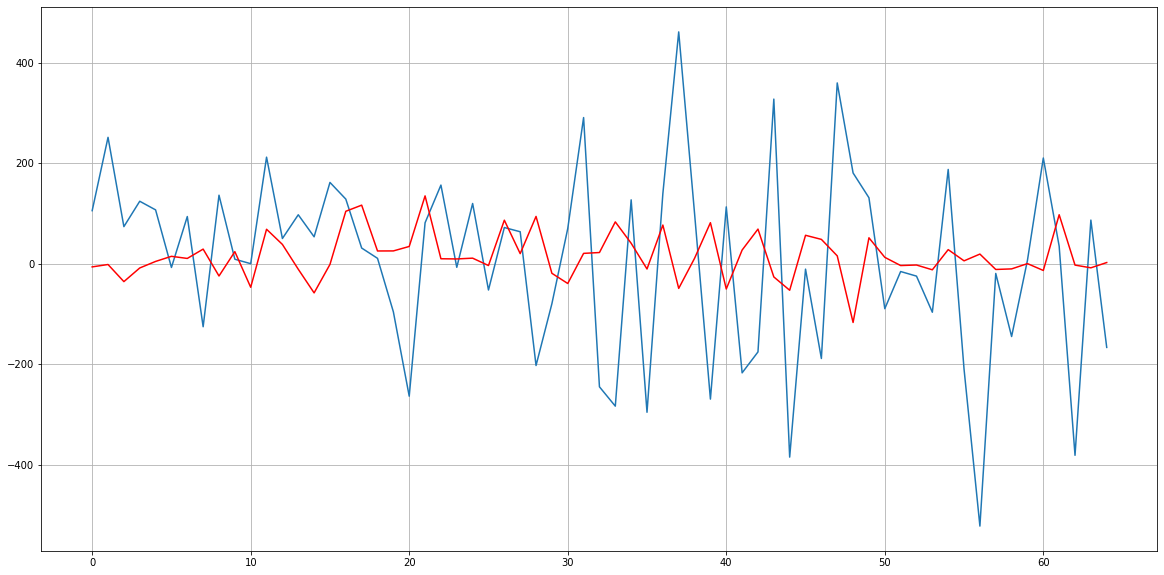

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(cart_ar.data_test["^IXIC"].values)
plt.plot(cart_ar.forecast_raw(), c='r')
plt.grid()

print("SUMA: ",sum(cart_ar.data_test["^IXIC"].values * cart_ar.forecast_raw() > 0), " / ", len(cart_ar.forecast_raw()))